In [1]:
import sys
sys.path.append("/Users/laurenzaisenpreis/Uni/Thesis/tweet-collector")

from fake_collector.utils.TwythonConnector import TwythonConnector
# from fake_collector.modules.user_profile_collector import UserProfileCollector
from fake_collector.utils.TwitterUser import TwitterUser
from fake_collector.configs.directory_config import Directories
from fake_collector.modules.user_profile_collector import UserProfileCollector

In [2]:
from fake_collector.modules.user_following_collector import UserFollowingCollector


# user_following_collector = UserFollowingCollector()

# twitter_app = TwythonConnector()
# twitter_app.make_connection()

# user_following_collector.add_user_friends_ids(first_10_users, twitter_app)


## Evaluate falsity scores of users

Method of selecting users:
- Select 1 bucket of users as "ground truth" these are the users only posting true news - from this bucket take TOP k according to labeled tweet count
- For the remaining users, normalize aggregated falsity score by their general tweet count and divide into 5 equal ranges, randomly select k users from each bucket for analysis

In [3]:
user_profile_collector = UserProfileCollector()

user_df = user_profile_collector.load_users_profiles_as_df()

In [5]:
users_object = user_profile_collector.load_users_profiles_as_dict()

In [6]:
# Add the labeled tweet count to the user df
user_df['labeled_tweet_count'] = user_df.apply(lambda x: len(users_object.get(x['user_id']).get_all_true_tweets_retweets()) + len(users_object.get(x['user_id']).get_all_false_tweets_retweets()), axis=1)

In [7]:
# user_df['weighted_aggregate_falsity_score'] = (user_df['aggregate_falsity_score'] * (user_df['labeled_tweet_count']/(user_df['labeled_tweet_count']+user_df['tweet_count']))) * 100

### Explore falsity score distribution

In [8]:
import pandas as pd

all_titles = pd.read_csv("../../data/fakenews_sources/all_politifact_0710nodub.csv")

<AxesSubplot: >

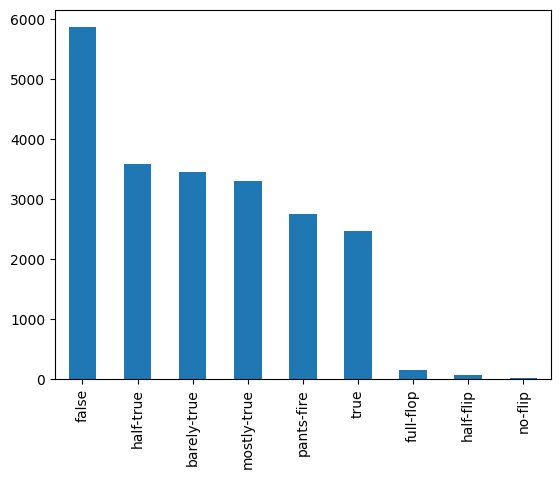

In [9]:
# Distribution of labels
all_titles[~all_titles.duplicated(subset=['claim'])]['truth_value'].value_counts().plot(kind='bar')

In [31]:
# Filter out users that only have replies (those ones have agg falsity score -1)
user_df = user_df[user_df['aggregate_falsity_score'] >= 0]

In [33]:
# users with at least one tweet
user_df = user_df[user_df['tweet_count'] > 0]

Mean labeled tweet count 2.723635803535645
Median labeled tweet count 1.0


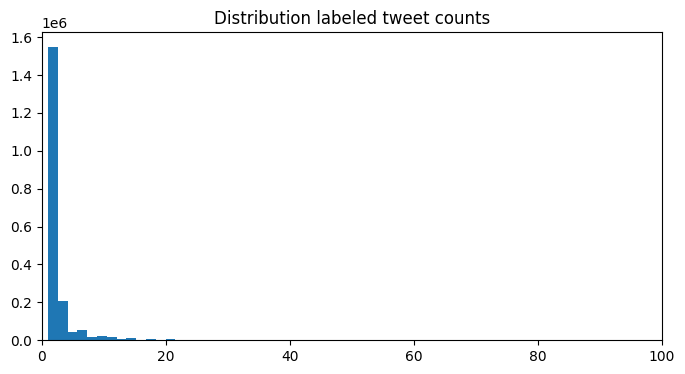

In [25]:
# Distribution of labeled tweet counts

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))

ax.hist(user_df['labeled_tweet_count'], bins=1000)
ax.set_xlim(0,100)

ax.title.set_text("Distribution labeled tweet counts")
print("Mean labeled tweet count", user_df['labeled_tweet_count'].mean())
print("Median labeled tweet count", user_df['labeled_tweet_count'].median())

In [57]:
# Calc tweet falsity score divided by tweetcount
user_df['avg_falsity_tweetcount'] = (user_df['aggregate_falsity_score'] / user_df['tweet_count'])*100

In [79]:
# Make first split true users vs other users
true_users = user_df[user_df['aggregate_falsity_score'] == 0]
other_users = user_df[~user_df['user_id'].isin(true_users['user_id'])]
print("Length true users ", len(true_users))
print("Length other users ", len(other_users))

Length true users  67410
Length other users  1906260


Max labeled tweet count 33


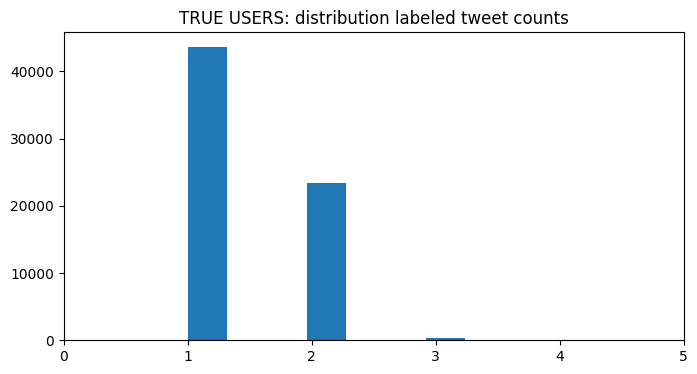

In [59]:
# Distribution of labeled tweet counts for true users

fig, ax = plt.subplots(figsize=(8,4))

ax.hist(true_users['labeled_tweet_count'], bins=100)
ax.set_xlim(0,5)

ax.title.set_text("TRUE USERS: distribution labeled tweet counts")
print("Max labeled tweet count", true_users['labeled_tweet_count'].max())

In [60]:
# Cut off user min tweet count for our labled tweets
other_users_cut = other_users[other_users['labeled_tweet_count']>10]

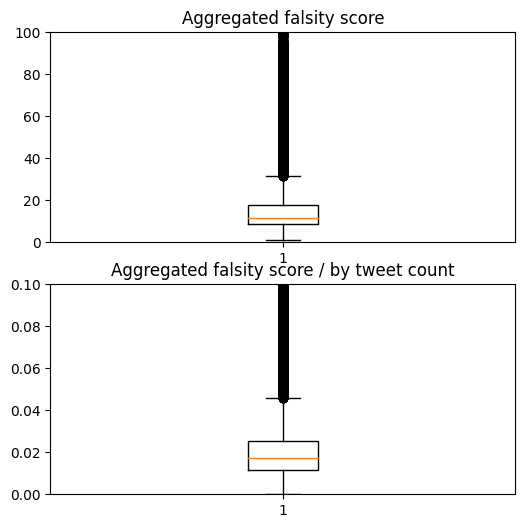

In [66]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,6))

ax1.boxplot(other_users_cut['aggregate_falsity_score'])
ax1.set_ylim(0,100)

ax2.boxplot(other_users_cut['avg_falsity_tweetcount'])
ax2.set_ylim(0,0.1)

ax1.title.set_text("Aggregated falsity score")
ax2.title.set_text("Aggregated falsity score / by tweet count")

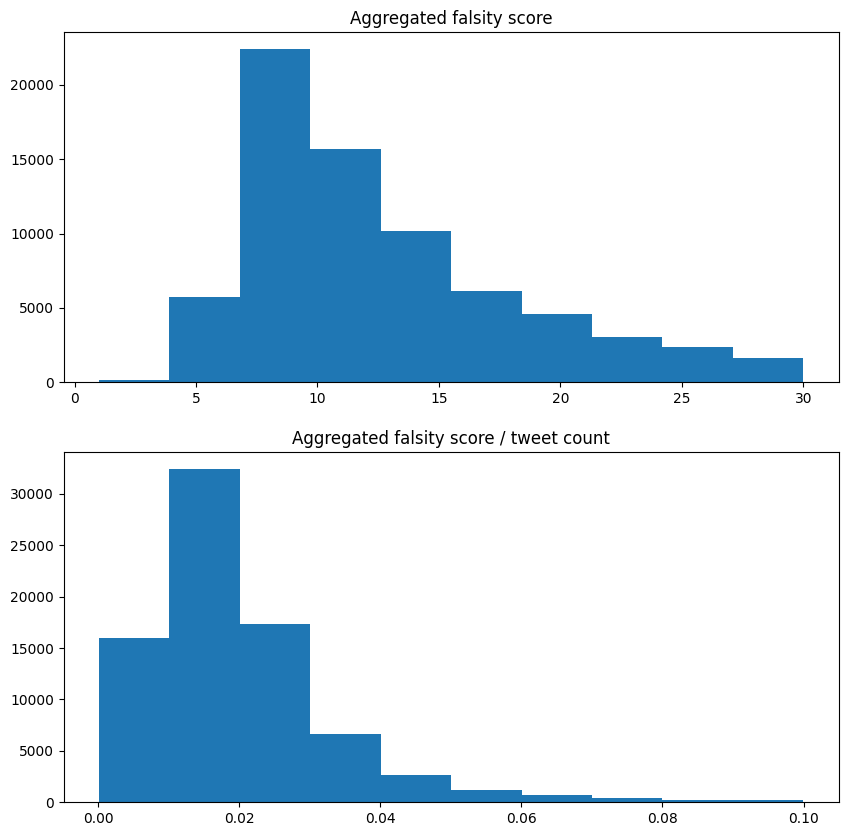

In [75]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10,10))

ax1.hist(other_users_cut[other_users_cut['aggregate_falsity_score'] < 30]['aggregate_falsity_score'])
ax2.hist(other_users_cut[other_users_cut['avg_falsity_tweetcount'] < 0.1]['avg_falsity_tweetcount'])

ax1.title.set_text("Aggregated falsity score")
ax2.title.set_text("Aggregated falsity score / tweet count")

In [78]:
other_users_cut[other_users_cut['avg_falsity_tweetcount'] == 0]

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,labeled_tweet_count,weighted_aggregate_falsity_score,avg_falsity_tweetcount


In [38]:
tweet_counter = 0
temp_falsity_score = 0
pants_tweets = []
for topic in users_object.get("16557179").tweets['pants-fire']:
    pants_tweets = pants_tweets + users_object.get("16557179").tweets['pants-fire'][topic]
temp_falsity_score += len(pants_tweets) * 1
tweet_counter += len(pants_tweets)

In [29]:
temp_falsity_score

6

### User buckets

In [8]:
import copy
# Make a copy of the initial objects / if any changes are done to the objects
# users_objects = copy.deepcopy(users_object)

In [9]:
# Filter out users that only have replies (those ones have agg falsity score -1)
print("Users prior ", len(user_df))
user_df = user_df[user_df['aggregate_falsity_score'] >= 0]
print("Users after ", len(user_df))

Users prior  1257207
Users after  1184308


In [10]:
# Check which users have posts ONLY true tweets or retweets
user_df['only_true'] = user_df.apply(lambda x: 1 if 
                        (len(users_object.get(x['user_id']).get_all_false_tweets_retweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_half_true_tweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_half_true_retweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_mostly_true_tweets()) == 0) 
                        & (len(users_object.get(x['user_id']).get_mostly_true_retweets()) == 0) 
                        else 0, axis=1)

In [11]:
print("Users with only TRUE news ", len(user_df[user_df['only_true'] == 1]))
only_true = user_df[user_df['only_true'] == 1].copy()

Users with only TRUE news  50083


In [12]:
# Get the true tweet count
only_true['true_tweet_count'] = only_true.apply(lambda x: (len(users_object.get(x['user_id']).get_true_tweets())) + len(users_object.get(x['user_id']).get_true_retweets()), axis=1)

In [13]:
only_true[only_true['true_tweet_count'] > 1]

,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,only_true,true_tweet_count
9758,1384493790,Kye,God don't make mistakes.,519,634,33767,False,2013-04-27T13:50:18.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,3
9775,2730072466,Disgruntled Die Easy Steelers Fan (1-3),Claflin Alumnus | ig: caiden__cook | 1911 🐶⚡️,882,665,40778,False,2014-07-31T17:42:43.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,3
9923,2770610031,Keith da Butler did it🔪,Artist ☥ ♑,406,725,14248,False,2014-09-15T00:51:17.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,2
10262,22495024,Daryl Hannah,love life xo dh,67428,2224,30996,True,2009-03-02T15:37:42.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,3
10308,945893366750904320,Elena Gravysimova,Gymternet and bad tv; proud cat mom; she/her,417,481,11509,False,2017-12-27T05:45:27.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228894,759490243,Jackie UCS,Climate change policy & impacts outreach for t...,276,299,743,False,2012-08-15T14:33:33.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,2
1228925,38827262,Steph Hao,,83,160,2374,False,2009-05-09T09:31:43.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,2
1229009,15587879,Lisa Sharp - Retro Housewife,"Oklahoma Native, Homemaker, Blogger, Lover of ...",4434,4235,28395,False,2008-07-24T19:56:33.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,2
1229140,767540874,TruthQuest ⚡ HODL,"Lover of God, Family, Country in that order. F...",212,532,1644,False,2012-08-19T13:12:13.000Z,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",0.0,0.0,[],[],1,2


In [14]:
# Users that have mostly fake news (everything except TRUE news)
mostly_fake = user_df[~user_df['user_id'].isin(only_true['user_id'])]

In [15]:
# Users that only post fake news (PANTS, FAKE, MOSTLY FAKE) and only post true news (HALF, MOSTLY, TRUE)
user_df['only_fake'] = user_df.apply(lambda x: 1 if (len(users_object.get(x['user_id']).get_all_true_tweets_retweets())) == 0 else 0, axis=1)

In [16]:
all_fake_labels_only = user_df[user_df['only_fake'] == 1]

In [17]:
all_true_labels_only = user_df[~user_df['user_id'].isin(all_fake_labels_only['user_id'])]

In [18]:
print("Only fake news users ", len(user_df[user_df['only_fake'] == 1]))
user_df[user_df['only_fake'] == 1].head(2)

Only fake news users  639169


,user_id,user_name,description,followers_count,friends_count,tweet_count,verified,created_at,tweets,retweets,replies,aggregate_falsity_score,average_falsity_score,following_ids,recent_tweets,only_true,only_fake
1,42120550,WIREDforFISHING,Post 2016 Independent/Democrat (Just couldn't ...,3282,4101,18037,False,2009-05-23T23:36:16.000Z,"{'pants-fire': {}, 'false': {'candidates-biogr...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",{'pants-fire': {'ethics': ['132589994802232934...,4.0,0.800000,[],[],0,1
2,711844276569681920,IBTimes Singapore,International Business Times (South-East Asia ...,1917,559,25765,True,2016-03-21T09:17:55.000Z,{'pants-fire': {'elections': ['133161503878066...,"{'pants-fire': {}, 'false': {}, 'mostly-false'...","{'pants-fire': {}, 'false': {}, 'mostly-false'...",10.4,1.485714,[],[],0,1


In [19]:
print("Users that have both true and fake news", len(user_df[(user_df['only_fake'] == 0) & (user_df['only_true'] == 0)]))

Users that have both true and fake news 495056


In [20]:
len(user_df[user_df['only_true'] == 1]) # 101895 Only true
len(user_df[user_df['only_fake'] == 1]) # 350860 Only fake
len(user_df[(user_df['only_fake'] == 0) & (user_df['only_true'] == 0)]) # 37850 both

495056

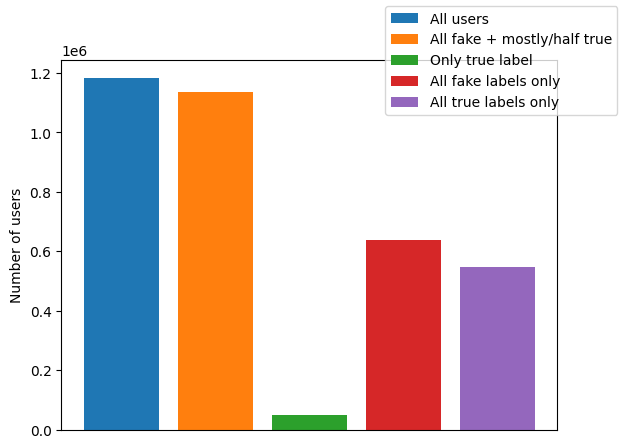

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

labels = ["Only true", "Only fake", "Both"]

ax.bar(1, len(user_df), label="All users")
ax.bar(2, len(mostly_fake), label="All fake + mostly/half true") # All the fake labels plus half, mostly true
ax.bar(3, len(only_true), label="Only true label")
ax.bar(4, len(all_fake_labels_only), label="All fake labels only") # All the fake labels NOT any true
ax.bar(5, len(all_true_labels_only), label="All true labels only") # All the fake labels NOT any true


ax.set_ylabel("Number of users")
fig.legend()
ax.axes.get_xaxis().set_visible(False)

In [22]:
# only_fake['normalized_falsity_score'] = only_fake.apply(lambda x: x['aggregate_falsity_score']/(1+users_obj.get(x['user_id']).tweet_count), axis=1)

In [23]:
# only_fake[only_fake['normalized_falsity_score'] > 0.009]['tweet_count'].mean()

<AxesSubplot: xlabel='aggregate_falsity_score', ylabel='Density'>

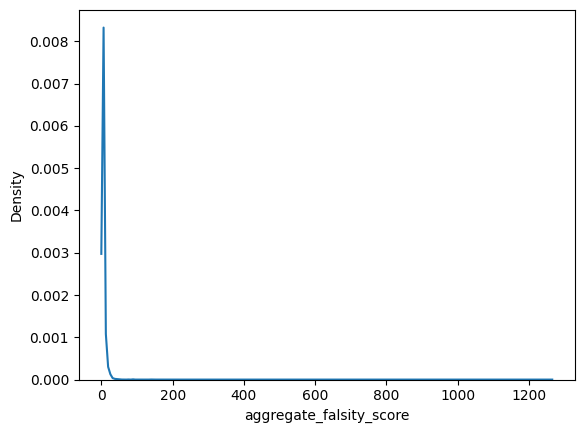

In [24]:
import seaborn as sns

sns.kdeplot(mostly_fake['aggregate_falsity_score']) 

<AxesSubplot: xlabel='aggregate_falsity_score', ylabel='Density'>

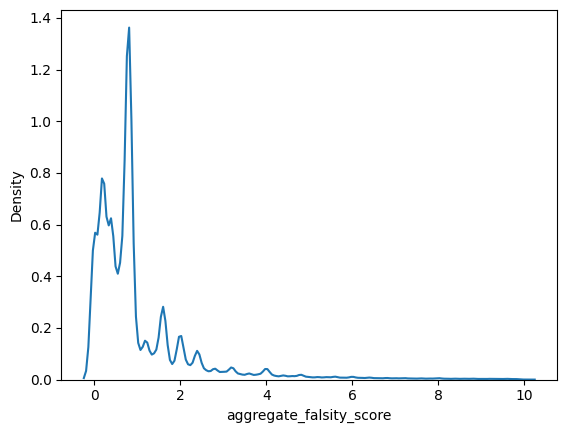

In [28]:
sns.kdeplot(mostly_fake[mostly_fake['aggregate_falsity_score'] < 10]['aggregate_falsity_score'])

<AxesSubplot: xlabel='aggregate_falsity_score', ylabel='Density'>

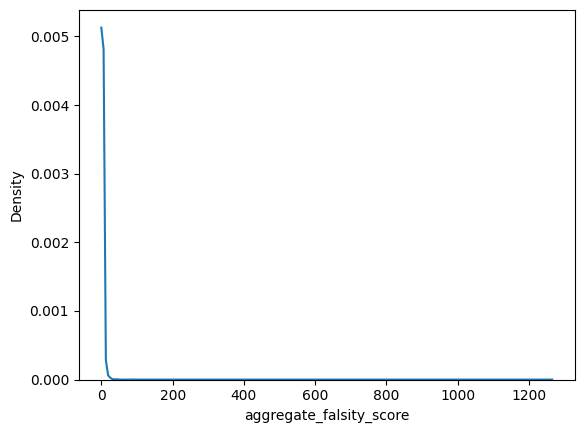

In [25]:
sns.kdeplot(all_fake_labels_only['aggregate_falsity_score']) 

<AxesSubplot: xlabel='true_tweet_count', ylabel='Density'>

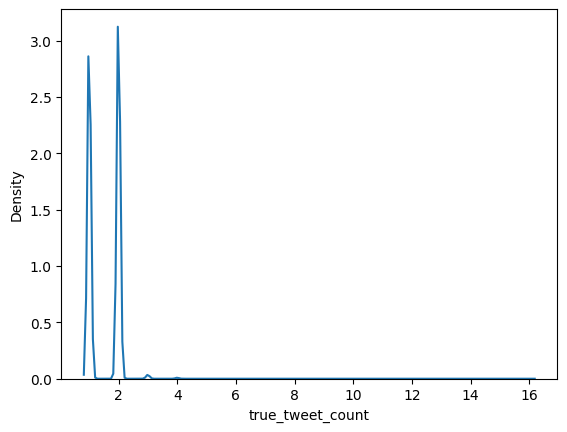

In [26]:
# Only true according to tweet count
sns.kdeplot(only_true['true_tweet_count'])

<AxesSubplot: xlabel='aggregate_falsity_score', ylabel='Density'>

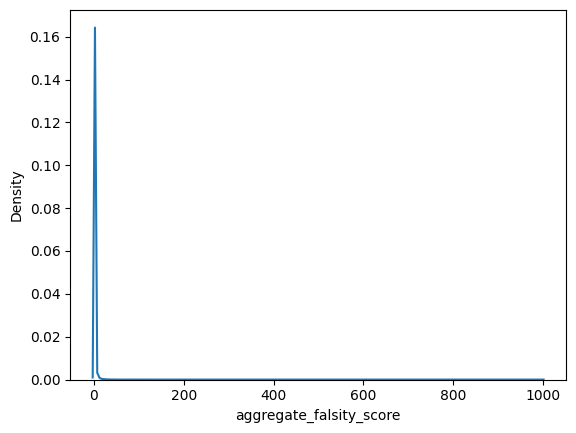

In [21]:
sns.kdeplot(both['aggregate_falsity_score'])

## Read all user profiles and add their falsity scores

In [38]:
# import required module
import os
import json
import re

directory = Directories()
path = directory.FAKE_NEWS_TWEETS

# iterate over files in that directory
tweets = []
for filename in os.listdir(path):
    if filename.startswith('0'):
        items = filename.split("_")
        for line in open(path / filename, 'r'):
            tweets.append((items[2],items[3],json.loads(line)))

Open file 00001_334_environment_barely-true_2022-03-03.json
topic  environment
label  barely-true
Open file 00001_1374_abortion_mostly-true_2010-01-14.json
topic  abortion
label  mostly-true
Open file 00001_1324_abortion_true_2011-06-06.json
topic  abortion
label  true
Open file 00001_1019_abortion_barely-true_2020-05-13.json
topic  abortion
label  barely-true
Open file 00001_997_abortion_half-true_2021-11-28.json
topic  abortion
label  half-true
Open file 00001_1008_abortion_false_2021-01-24.json
topic  abortion
label  false
Open file 00001_882_environment_pants-fire_2010-06-02.json
topic  environment
label  pants-fire
Open file 00001_202_climate-change_barely-true_2014-05-14.json
topic  climate-change
label  barely-true
Open file 00001_737_environment_barely-true_2012-03-20.json
topic  environment
label  barely-true
Open file 00001_575_environment_barely-true_2015-01-13.json
topic  environment
label  barely-true
Open file 00001_408_environment_false_2019-09-04.json
topic  environment

In [39]:
len(tweets)

3802

In [8]:
users = {}

for tweet in tweets:
    try:
        if 'includes' in tweet[2].keys():
            for user in tweet[2]["includes"]["users"]:
                user_id = user["id"]
                if user_id not in users:
                    users[user_id] = TwitterUser(user_id=user_id, user_name=user["name"], description=user['description'], followers_count=user["public_metrics"]["followers_count"], friends_count=user["public_metrics"]["following_count"], tweet_count=user["public_metrics"]["tweet_count"], verified=user["verified"], created_at=user["created_at"])
    except:
        print("Problem with tweet user", user)

In [37]:
len(tweets)

NameError: name 'tweets' is not defined

In [10]:
""""DEBUGGING"""

try:
    topic = tweets[4][0]
    label = tweets[4][1]
    for tweet in tweets[4][2]["data"]:

        # get corresponding user
        author_id = int(tweet["author_id"])
        tweet_id = int(tweet["id"])

        # get type if present
        if 'referenced_tweets' in tweet.keys():
            tweet_type = tweet['referenced_tweets'][0]['type']
        else:
            tweet_type = 'tweet'
        # add tweet info to user

        user_obj = users.get(author_id)

        match tweet_type:
            case "tweet":
                if topic not in user_obj.tweets[label].keys():
                    user_obj.tweets[label]['topic'] = [tweet_id]
                else:
                    user_obj.tweets[label]['topic'].append(tweet_id)
            case "retweeted":
                if topic not in user_obj.retweets[label].keys():
                    user_obj.retweets[label]['topic'] = [tweet_id]
                else:
                    user_obj.retweets[label]['topic'].append(tweet_id)
            case "replied_to":
                if topic not in user_obj.replies[label].keys():
                    user_obj.replies[label]['topic'] = [tweet_id]
                else:
                    user_obj.replies[label]['topic'].append(tweet_id)
        # user_obj.add_fake_news_tweet(tweet_id)
except:
    print("Problem with tweet ", tweet)

Problem with tweet  {'referenced_tweets': [{'type': 'retweeted', 'id': '1551998427461869568'}], 'lang': 'en', 'edit_history_tweet_ids': ['1552048842660581378'], 'id': '1552048842660581378', 'public_metrics': {'retweet_count': 4, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'created_at': '2022-07-26T21:50:54.000Z', 'text': 'RT @essenviews: This is a lie:\nRepublican Gov Tate Reeves: “Mississippi will still have a law on the books in which 39 countries, 39 out of…', 'conversation_id': '1552048842660581378', 'author_id': '1343686999178412033'}


In [11]:
users.get('1343686999178412033').retweets

{'pants-fire': {},
 'false': {},
 'mostly-false': {},
 'half-true': {},
 'mostly-true': {},
 'true': {}}

In [12]:
tw = {'author_id': '185741133', 'in_reply_to_user_id': '185741133', 'referenced_tweets': [{'type': 'replied_to', 'id': '1531626899273039872'}], 'lang': 'en', 'public_metrics': {'retweet_count': 0, 'reply_count': 1, 'like_count': 0, 'quote_count': 0}, 'id': '1531627154706153473', 'created_at': '2022-05-31T13:22:24.000Z', 'text': '"Ron Johnson\nstated on May 11, 2022 in News release:\nIn the immediate wake of a fire and vandalism at the Madison headquarters of an anti-abortion group, Democrats had not condemned “activists who are engaging in this repugnant illegal activity.”\n\nSome Democrats did and some did', 'edit_history_tweet_ids': ['1531627154706153473'], 'conversation_id': '1531626899273039872'}

In [13]:
 # get corresponding user
author_id = tw["author_id"]
tweet_id = tw["id"]
# get type if present
if 'referenced_tweets' in tw.keys():
    tweet_type = tw['referenced_tweets'][0]['type']
else:
    tweet_type = 'tweet'
# add tweet info to user

user_obj = users.get('185741133')

match tweet_type:
    case "tweet":
        if topic not in user_obj.tweets[label].keys():
            user_obj.tweets[label][topic] = [tweet_id]
        else:
            user_obj.tweets[label][topic].append(tweet_id)
    case "retweeted":
        if topic not in user_obj.retweets[label].keys():
            user_obj.retweets[label][topic] = [tweet_id]
        else:
            user_obj.retweets[label][topic].append(tweet_id)
    case "replied_to":
        if topic not in user_obj.replies[label].keys():
            user_obj.replies[label][topic] = [tweet_id]
        else:
            user_obj.replies[label][topic].append(tweet_id)

In [14]:
users.get('185741133').replies

{'pants-fire': {},
 'false': {},
 'mostly-false': {},
 'half-true': {'abortion': ['1531627154706153473']},
 'mostly-true': {},
 'true': {}}

In [16]:
problem_counter = 0

for entry in tweets:

    topic = entry[0]
    label = entry[1]
    if label == 'barely-true':
        label = 'mostly-false' # https://www.politifact.com/article/2011/jul/27/-barely-true-mostly-false/

    try:
        if "data" in entry[2].keys():
            for tweet in entry[2]["data"]:
                # get corresponding user
                author_id = tweet["author_id"]
                tweet_id = tweet["id"]
                # get type if present
                if 'referenced_tweets' in tweet.keys():
                    tweet_type = tweet['referenced_tweets'][0]['type']
                else:
                    tweet_type = 'tweet'
                # add tweet info to user

                user_obj = users.get(author_id)

                match tweet_type:
                    case "tweet":
                        if topic not in user_obj.tweets[label].keys():
                            user_obj.tweets[label][topic] = [tweet_id]
                        else:
                            user_obj.tweets[label][topic].append(tweet_id)
                    case "retweeted":
                        if topic not in user_obj.retweets[label].keys():
                            user_obj.retweets[label][topic] = [tweet_id]
                        else:
                            user_obj.retweets[label][topic].append(tweet_id)
                    case "replied_to":
                        if topic not in user_obj.replies[label].keys():
                            user_obj.replies[label][topic] = [tweet_id]
                        else:
                            user_obj.replies[label][topic].append(tweet_id)
    except:
        print("issue with tweet ", tweet)

issue with tweet  {'in_reply_to_user_id': '270459817', 'edit_history_tweet_ids': ['1556919275352375296'], 'referenced_tweets': [{'type': 'replied_to', 'id': '1556903277538713602'}], 'conversation_id': '1556903277538713602', 'text': '@RevRichardColes Richard please do a research paper on humans farts and whether they contribute to global warming. Might take the pressure of the bovine community!', 'author_id': '960443641843142656', 'lang': 'en', 'id': '1556919275352375296', 'created_at': '2022-08-09T08:24:16.000Z', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}}
issue with tweet  {'author_id': '960443641843142656', 'edit_history_tweet_ids': ['1556919275352375296'], 'id': '1556919275352375296', 'public_metrics': {'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}, 'referenced_tweets': [{'type': 'replied_to', 'id': '1556903277538713602'}], 'created_at': '2022-08-09T08:24:16.000Z', 'in_reply_to_user_id': '270459817', 'text':

In [ ]:
max_fake = 0
user_id = ""
for user in users.values():
    if len(user.get_all_true_tweets()) > max_fake:
        max_fake = len(user.get_all_true_tweets())
        user_id = user.get_user_id()

In [ ]:
users.get(user_id).user_name

In [ ]:
for user in users.values():
    user.calculate_falsity_score()

In [ ]:
falsity_score = 1
user_id = ""
for user in users.values():
    if user.falsity_score < falsity_score and user.falsity_score != -1:
        falsity_score = user.falsity_score
        user_id = user.get_user_id()

In [ ]:
users.get('312149882').falsity_score

# Issue: Politico (official news outlet) classified as very false??

In [ ]:
# 3 true retweets
# 1 false retweet 0.2
# 1 pants fire retweet 0
# 9 pants fire tweets 0
# 3 false tweets 0.6
# 310 true tweets 1

# sum: 327 
count = 3 + 0.2 + 0.6 + 310 
count / 327

In [ ]:
counter = 0
for user in users.values():
    if user.falsity_score == -1:
        counter += 1
print(counter)
# 67114 with only replies

In [ ]:
len(users)

In [ ]:
# '1538903558' most fake news
# '312149882' most true news

## Users latest tweets

In [ ]:
print("Starting connection")
twitter_app = TwythonConnector()
twitter_app.make_connection()
print("established connection")
# print("Rate limit status", twitter_app.twitter_connection.get_application_rate_limit_status())

rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
# print(rate_limit_stats["resources"]["friends"]["/friends/ids"])

latest_tweets = twitter_app.twitter_connection.get_user_timeline(user_id=272065025,count=200 ,tweet_mode='extended')

# tweets = []

# cursor=-1
# while cursor != 0:
#     latest_tweets = twitter_app.twitter_connection.get_friends_ids(user_id=272065025, cursor=cursor, count=5000)
#     tweets.append(latest_tweets['ids'])
#     print(len(latest_tweets))
#     cursor = latest_tweets['next_cursor']

In [ ]:
latest_tweets

In [ ]:
"""
Trying out with regular API
"""



## Elite Falsity scores

In [ ]:
import pandas as pd

df = pd.read_csv("../../data/falsity_scores/falsity.scores.csv")

df.head()

In [ ]:
duplicated_ids = df.groupby("elite_id_str").agg(
    
    counter=("elite_id_str", 'count')
    
).sort_values(by="counter", ascending=False)

duplicated_ids[duplicated_ids["counter"] > 1]

# Some elites have duplicated ids but they have exactly the same accounts, weights and scores

In [ ]:
df = df.drop_duplicates(subset='elite_id_str', keep='first')

falsity_dict = df.set_index('elite_id_str').to_dict('index')

In [ ]:
from fake_collector.modules.user_profile_collector import UserProfileCollector

user_profile = UserProfileCollector()

users = user_profile.load_users_profiles_as_df()

users_obj = user_profile.load_user_profiles()

In [ ]:
users["no_fake_news_tweets"] = users['fake_news_tweets'].str.len()
# max is 16

In [ ]:
users[users["no_fake_news_tweets"] == 16] # user with most fake news tweets

In [ ]:
users[users["no_fake_news_tweets"] == 16]["fake_news_tweets"].values[0] # user with most fake news tweets

In [ ]:
for idx,user in enumerate(users_obj):
    if user.get_user_id() == 2545174222:
        index = idx
fake_news_user = users_obj[index] # grab users with max fake news tweets

In [ ]:
from fake_collector.modules.user_following_collector import UserFollowingCollector

print("Starting connection")
twitter_app = TwythonConnector()
twitter_app.make_connection()
print("established connection")

users_following_collector = UserFollowingCollector()

# fetch following ids for given user

users_following_collector.add_user_friends_ids([fake_news_user], twitter_app=twitter_app)

In [ ]:
for friend in fake_news_user.following_ids:
    if friend in falsity_dict.keys():
        print(falsity_dict[friend])
# User with max fake news is following 16 falsity accounts (of 54 friends in total!)

In [ ]:
users[users["user_id"].isin(falsity_dict.keys())]

## Store all users as objects

In [ ]:
import json
path = "../../data/fakenews_tw_output/00001_6_coronavirus_false_2021-02-01.json"
file = open(path,'r')
tweets = []
for line in open(path, 'r'):
    tweets.append(json.loads(line))  

In [ ]:
# import required module
import os
import json 

directory = Directories()
path = directory.FAKE_NEWS_TWEETS

# iterate over files in that directory
tweets = []
for filename in os.listdir(path):
    if filename.startswith('0'):
        file = open(path / filename, 'r')
        for line in open(path / filename, 'r'):
            tweets.append(json.loads(line))

In [ ]:
try:
    for bucket in tweets:
        for tweet in bucket["data"]:
             if tweet['id'] == '1372321579418447874':
                print(tweet)
except:
    pass

In [ ]:
tweets[9]["data"]

In [ ]:
# get user information
users = {}
counter = 0
for tweet in tweets:
    try:
        for user in tweet["includes"]["users"]:
            user_id = int(user["id"])
            if user_id not in users:
                users[user_id] = TwitterUser(user_id=user_id, user_name=user["name"], followers_count=user["public_metrics"]["followers_count"], friends_count=user["public_metrics"]["following_count"], tweet_count=user["public_metrics"]["tweet_count"], verified=user["verified"], created_at=user["created_at"])
    except:
        print("Problem with tweet user", user)

In [ ]:
example = users[185741133]

for tweet in tweets:
    try:
        for tweet in tweet["data"]:
            # get corresponding user
            author_id = int(tweet["author_id"])
            tweet_id = int(tweet["id"])

            user_obj = users.get(author_id)
            user_obj.add_fake_news_tweet(tweet_id)
    except:
        print("Problem with tweet ", tweet)

In [ ]:
import pickle
directory = Directories()

# users_list = list(users.values())
path = directory.USERS_PATH
filename = "users.pickle"

# load to file
# with open(path / filename, "wb") as f:
#     pickle.dump(users_list, f)

# Open pickle file
with open(path / filename, "rb") as f:
    users_loaded = pickle.load(f)

## Get following ids of Users

In [ ]:
from fake_collector.modules.user_following_collector import UserFollowingCollector

following_collector = UserFollowingCollector()

results = following_collector.add_user_friends_ids(user_list=test_cursor, twitter_app=twitter_app)

In [ ]:
rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
rate_limit_stats["resources"]["friends"]["/friends/ids"]

In [ ]:
import time
import datetime
from twython import TwythonRateLimitError

for user in test_cursor:
            print("Trying user ", user.user_name)
            cursor = -1
            while cursor != 0:
                try:
                    print ('in WHILE')
                  
                    response = twitter_app.twitter_connection.get_friends_ids(user_id=user.get_user_id(), cursor=cursor, count=5000)
                
                    following_ids = response['ids']
                    print("Length of following ids: ", len(following_ids))
                    user.add_following_ids(following_ids)
                    print("Added following ids, currently at: ", len(user.following_ids))
                    cursor = response['next_cursor']
                    #print ids
                    # for x in ids:
                    # 	fp2.write(str(x) + ',')
                    # if cursor == 0:
                    # 	fp2.write('\n')

                except TwythonRateLimitError as error:
                    print("Hit limit")
                    rate_limit_stats = twitter_app.twitter_connection.get_application_rate_limit_status()
                    remaining_time = rate_limit_stats["resources"]["friends"]["/friends/ids"]["reset"]
                    remainder = remaining_time - time.time() # epoch time
                    #Sleeping for X minutes
                    minutes = remainder // 60 % 60
                    print("Sleeping for minutes: ", minutes)
                    time.sleep(remainder)
                    twitter_app.make_connection() # make a new connection
                    continue

                       

In [ ]:
for user in users_to_fetch:

    user_following_ids = []

    rate_limit_info = twitter_app.twitter_connection.get_application_rate_limit_status()

    while rate_limit_info['limit'] > rate_limit_info['remaining']:

        user_following = twitter_app.twitter_connection.get_friends_ids(user.user_id)
        user_following_ids.append(user_following)
    
    

    print(rate_limit_stats["resources"]["friends"]["/friends/ids"])

In [ ]:
from datetime import datetime
ts = int('1664538201')
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

In [ ]:
user_collector = UserProfileCollector()
user_collector.get_user_info(272065025,twitter_app)